# Unet Implementation

In [156]:
import pickle
import gzip
import numpy as np
import os
import time
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
from torchsummary import summary

In [52]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

### Helper functions

In [53]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [118]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
        
def flatten(dicts):
    
    # extract the annotated video frames, their labels
    # and the boxes
    
    images = []
    boxes = []
    labels = []
    
    for i, dic in enumerate(dicts):
        
        video = dic['video']
        frames = dic['frames']
        dic_labels = dic['label']
        
        images.append((video[:,:,frames[0]] / 255).astype('float32'))
        images.append((video[:,:,frames[1]] / 255).astype('float32'))
        images.append((video[:,:,frames[2]] / 255).astype('float32'))
        
        labels.append(dic_labels[:,:,frames[0]].astype('float32'))
        labels.append(dic_labels[:,:,frames[1]].astype('float32'))
        labels.append(dic_labels[:,:,frames[2]].astype('float32'))
        
        boxes.append(dic['box'].astype('uint8'))
        boxes.append(dic['box'].astype('uint8'))
        boxes.append(dic['box'].astype('uint8'))
        
    return images, boxes, labels

def resize(images, boxes, labels, size):
    
    # resize images, boxes and labels

    for i in range(len(images)):
        
        images[i] = cv2.resize(images[i], size, interpolation = cv2.INTER_CUBIC)
        boxes[i] = cv2.resize(boxes[i], size, interpolation = cv2.INTER_CUBIC)
        labels[i] = cv2.resize(labels[i], size, interpolation = cv2.INTER_CUBIC)
        
        # add number of channels (in this case 1) at the front for the
        # right input shape for the pytorch layers
        
        images[i] = np.expand_dims(images[i], axis=0)
        images[i] = np.expand_dims(images[i], axis=0)
        
        labels[i] = np.expand_dims(labels[i], axis=0)
        
    return np.concatenate(images, axis=0), boxes, np.concatenate(labels, axis=0)

### Load data

In [119]:
# load data
train_data = load_zipped_pickle("data/train.pkl")
test_data = load_zipped_pickle("data/test.pkl")

In [120]:
size = (128, 128)

### Preprocessing

In [229]:
images, boxes, labels = flatten(train_data)
images, boxes, labels = resize(images, boxes, labels, size)

In [230]:
train_images = torch.from_numpy(images[184:]).to(device)
train_labels = torch.from_numpy(labels[184:]).to(device)
# TODO: add data augmentation, denoising, other preprocessing steps?
# TODO: split into train and validation sets

### Model

In [231]:
class Unet(nn.Module):
    
    def __init__(self, filters=64):
        
        super().__init__()
        
        self.max_pool = nn.MaxPool2d(2)
        
        self.block_enc_1 = self.conv_block(1, filters)
        self.block_enc_2 = self.conv_block(filters, 2*filters)
        self.block_enc_3 = self.conv_block(2*filters, 4*filters)
        
        self.block_inbetween = self.conv_block(4*filters, 8*filters, True)
        
        self.block_dec_1 = self.conv_block(8*filters, 4*filters, True)
        self.block_dec_2 = self.conv_block(4*filters, 2*filters, True)
        
        self.block_last = self.conv_block(2*filters, filters, True, True)
        
    def conv_block(self, channels, filters, enc=False, last=False):
        
        modules = []
        
        modules.append(nn.Conv2d(channels, filters, 3, 1, padding='same'))
        modules.append(nn.ReLU())
        modules.append(nn.Conv2d(filters, filters, 3, 1, padding='same'))
        modules.append(nn.ReLU())

        if enc:
            if not last:
                modules.append(nn.ConvTranspose2d(filters, filters//2, 2, stride=(2,2)))
            else:
                modules.append(nn.Conv2d(filters, 1, 1, 1))
                modules.append(nn.Sigmoid())
            
        return nn.Sequential(*modules)
            
    def forward(self, x):
        
        # encoder
        
        x1 = self.block_enc_1(x)
        x2 = self.max_pool(x1)
        
        x3 = self.block_enc_2(x2)
        x4 = self.max_pool(x3)
        
        x5 = self.block_enc_3(x4)
        x6 = self.max_pool(x5)
        
        # between encoder and decoder
        
        x7 = self.block_inbetween(x6)
        
        # decoder
        
        x8 = self.block_dec_1(torch.cat((x7, x5), dim=1))
        x9 = self.block_dec_2(torch.cat((x8, x3), dim=1))
        
        x10 = self.block_last(torch.cat((x9, x1), dim=1))
        
        return x10

### Train

In [232]:
def iou(inputs, targets):       
        
        inputs = inputs.squeeze()
        inputs = torch.round(inputs)
        
        intersection = (inputs * targets).sum(dim=(1, 2))
        total = (inputs + targets).sum(dim=(1, 2))
        union = total - intersection 
        
        IoU = intersection / union
                
        return IoU

In [233]:
def val_loss(model, val_loader):
    # TODO: calculate IoU for validation dataset

IndentationError: expected an indented block (3965556404.py, line 2)

In [238]:
unet = Unet(filters=64).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = smp.losses.JaccardLoss(mode='binary')
#criterion = torch.nn.BCEWithLogitsLoss()

In [239]:
train_tensorset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_tensorset, batch_size=5)

### Train Loop

In [240]:
for epoch in range(1000):
    
    t = time.time()
    num_samples_epoch = 0
    train_loss_cum = 0
    IoU = torch.Tensor().to(device)
    
    for x,y in train_loader:
        
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        unet.train()
        output = unet(x)
        loss = criterion(output.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()
        
        # keep track of training loss
        num_samples_epoch += x.shape[0]
        train_loss_cum += loss * x.shape[0]
        
        # need the median IoU
        #unet.eval()
        with torch.no_grad():
            IoU = torch.cat((IoU, iou(output, y)))
    train_loss = train_loss_cum / num_samples_epoch
    train_iou = torch.median(IoU)   
    epoch_duration = time.time() - t
    
    if train_iou > 0.6:
        break
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} | Train IoU: {train_iou:.4f} | '
              f'Train loss: {train_loss:.4f} | '
              #f' Validation loss: {val_loss:.4f} | '
              f' Duration {epoch_duration:.2f} sec')

Epoch 0 | Train IoU: 0.0067 | Train loss: 0.9933 |  Duration 3.85 sec
Epoch 5 | Train IoU: 0.0067 | Train loss: 0.9933 |  Duration 0.06 sec
Epoch 10 | Train IoU: 0.0067 | Train loss: 0.9930 |  Duration 0.06 sec
Epoch 15 | Train IoU: 0.0157 | Train loss: 0.9926 |  Duration 0.06 sec
Epoch 20 | Train IoU: 0.0203 | Train loss: 0.9924 |  Duration 0.06 sec
Epoch 25 | Train IoU: 0.0189 | Train loss: 0.9916 |  Duration 0.06 sec
Epoch 30 | Train IoU: 0.0201 | Train loss: 0.9916 |  Duration 0.06 sec
Epoch 35 | Train IoU: 0.0239 | Train loss: 0.9914 |  Duration 0.06 sec
Epoch 40 | Train IoU: 0.0253 | Train loss: 0.9914 |  Duration 0.07 sec
Epoch 45 | Train IoU: 0.0244 | Train loss: 0.9913 |  Duration 0.06 sec
Epoch 50 | Train IoU: 0.0642 | Train loss: 0.9912 |  Duration 0.06 sec
Epoch 55 | Train IoU: 0.0594 | Train loss: 0.9909 |  Duration 0.06 sec
Epoch 60 | Train IoU: 0.0855 | Train loss: 0.9908 |  Duration 0.07 sec
Epoch 65 | Train IoU: 0.1373 | Train loss: 0.9907 |  Duration 0.06 sec
Epoch 70

In [ ]:
from torchsummary import summary
summary = summary(unet, (1, 128, 128))

In [243]:
unet = unet.to('cpu')
train_images = train_images.to('cpu')
res = unet(train_images)

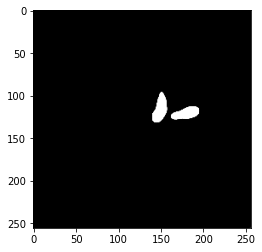

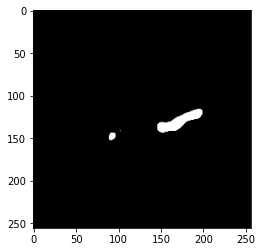

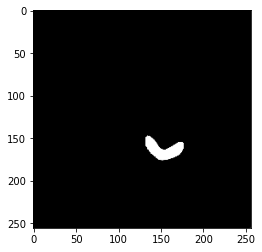

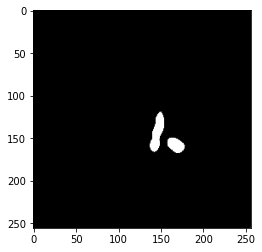

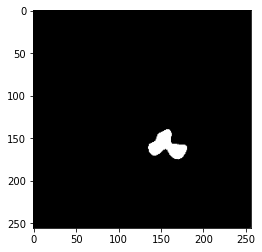

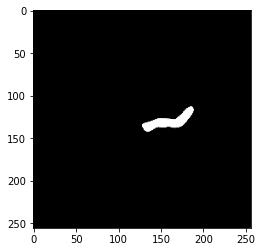

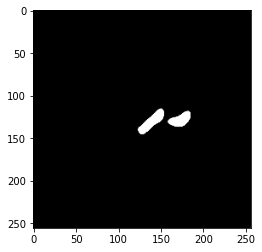

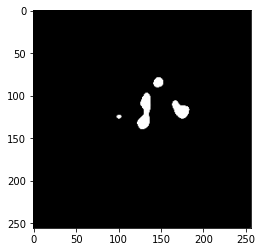

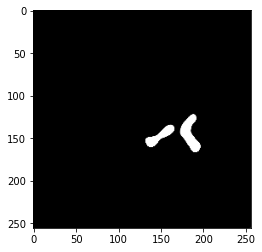

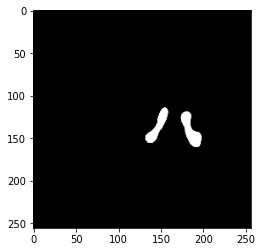

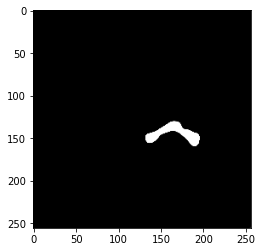

In [246]:
for i in range(res.shape[0]):
    plt.imshow(res[i].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.show()

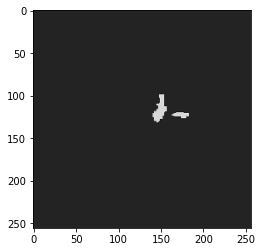

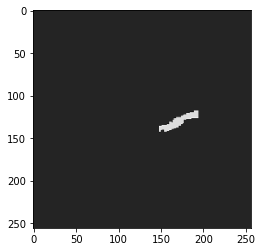

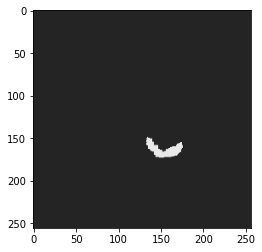

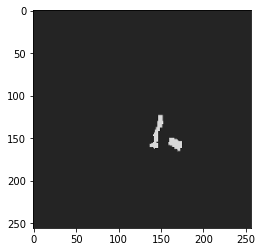

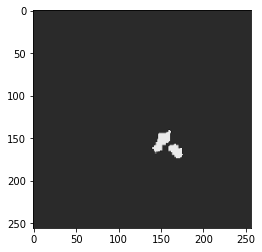

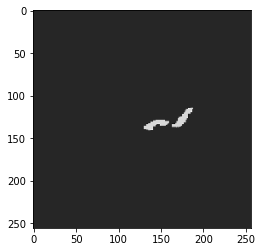

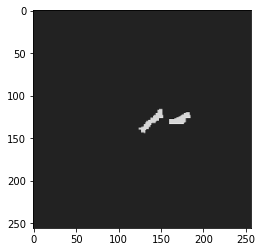

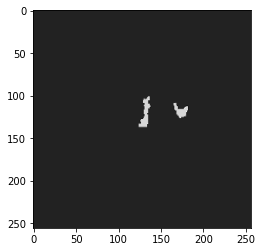

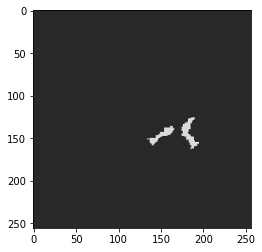

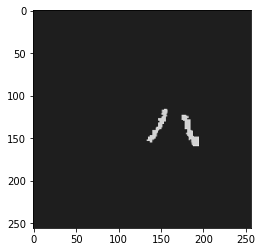

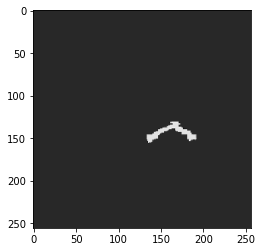

In [248]:
for i in range(res.shape[0]):
    plt.imshow(train_labels[i].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.show()

In [251]:
iou(res, train_labels.to('cpu'))

tensor([0.4955, 0.5841, 0.6951, 0.5456, 0.5525, 0.5830, 0.6261, 0.4557, 0.5603,
        0.5930, 0.5948], grad_fn=<DivBackward0>)